In [1]:
!pip install -q gdown tensorflow ultralytics

In [2]:
import zipfile
import os
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, EfficientNetB0
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.svm import SVC
from matplotlib import pyplot as plt
import numpy as np

In [3]:
working_dir = '/kaggle/working'
os.makedirs(working_dir, exist_ok=True)

In [4]:
base_dir = '/kaggle/input/recycle'
for class_dir in os.listdir(base_dir):
    src_dir = os.path.join(base_dir, class_dir)
    dst_dir = os.path.join(working_dir, class_dir)
    if os.path.isdir(src_dir):
        shutil.copytree(src_dir, dst_dir)

In [5]:
train_dir = os.path.join(working_dir, 'train')
val_dir = os.path.join(working_dir, 'validation')
test_dir = os.path.join(working_dir, 'test')

In [6]:
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

In [7]:
class_dirs = [os.path.join(working_dir, d) for d in os.listdir(working_dir) if os.path.isdir(os.path.join(working_dir, d))]
for class_dir in class_dirs:
    class_name = os.path.basename(class_dir)
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    
    if len(images) > 1: 
        # Split the data
        train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)
        val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

        # Move images to the respective directories
        for img in train_images:
            shutil.move(os.path.join(class_dir, img), os.path.join(train_dir, class_name, img))
        for img in val_images:
            shutil.move(os.path.join(class_dir, img), os.path.join(val_dir, class_name, img))
        for img in test_images:
            shutil.move(os.path.join(class_dir, img), os.path.join(test_dir, class_name, img))


In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   brightness_range=[0.8, 1.2],
                                   fill_mode='nearest')

In [9]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 9009 images belonging to 8 classes.


In [11]:
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 1931 images belonging to 8 classes.


In [12]:
test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 1933 images belonging to 8 classes.


In [13]:
def build_model(base_model, trainable_layers=-4, input_shape=(224, 224, 3)):
    base_model.trainable = True
    for layer in base_model.layers[:trainable_layers]:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.6)(x)
    output = Dense(train_generator.num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [14]:
input_shape = (224, 224, 3)

vgg16_model = build_model(VGG16(weights='imagenet', include_top=False, input_shape=input_shape))
vgg19_model = build_model(VGG19(weights='imagenet', include_top=False, input_shape=input_shape))
resnet_model = build_model(ResNet50(weights='imagenet', include_top=False, input_shape=input_shape))
efficientnet_model = build_model(EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
X_train_svm, y_train_svm = next(train_generator)
X_train_svm = X_train_svm.reshape(X_train_svm.shape[0], -1)

In [17]:
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
y_train_svm = np.argmax(y_train_svm, axis=1)

svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_svm, y_train_svm)

SVC(kernel='linear', probability=True)

In [18]:
checkpoint_vgg16 = ModelCheckpoint('vgg16_best_weights.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_vgg19 = ModelCheckpoint('vgg19_best_weights.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_resnet = ModelCheckpoint('resnet_best_weights.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_efficientnet = ModelCheckpoint('efficientnet_best_weights.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_cnn = ModelCheckpoint('cnn_best_weights.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.00001)

In [19]:
vgg16_history = vgg16_model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint_vgg16, early_stopping])

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729017089.315733     118 service.cc:145] XLA service 0x7ccbb4002670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729017089.315823     118 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/282 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.1953 - loss: 3.4446   

I0000 00:00:1729017101.318940     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.4653 - loss: 2.0151
Epoch 1: val_loss improved from inf to 1.24808, saving model to vgg16_best_weights.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 164s 519ms/step - accuracy: 0.4656 - loss: 2.0139 - val_accuracy: 0.6815 - val_loss: 1.2481
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6596 - loss: 1.2705
Epoch 2: val_loss improved from 1.24808 to 0.97655, saving model to vgg16_best_weights.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 140s 484ms/step - accuracy: 0.6597 - loss: 1.2703 - val_accuracy: 0.7654 - val_loss: 0.9765
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7320 - loss: 1.0361
Epoch 3: val_loss improved from 0.97655 to 0.85558, saving model to vgg16_best_weights.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 140s 485ms/step - accuracy: 0.7320 - loss: 1.0361 - val_accuracy: 0.7809 - val_loss: 0.8556
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7440 - loss: 0.9405
Epoch 4: val_loss imp

In [20]:
vgg19_history = vgg19_model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint_vgg19, early_stopping])

Epoch 1/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.4519 - loss: 2.0042
Epoch 1: val_loss improved from inf to 1.40254, saving model to vgg19_best_weights.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 141s 474ms/step - accuracy: 0.4523 - loss: 2.0030 - val_accuracy: 0.6603 - val_loss: 1.4025
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6443 - loss: 1.2825
Epoch 2: val_loss improved from 1.40254 to 1.07096, saving model to vgg19_best_weights.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 138s 478ms/step - accuracy: 0.6443 - loss: 1.2824 - val_accuracy: 0.7204 - val_loss: 1.0710
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.6906 - loss: 1.0944
Epoch 3: val_loss improved from 1.07096 to 0.88665, saving model to vgg19_best_weights.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 134s 465ms/step - accuracy: 0.6906 - loss: 1.0944 - val_accuracy: 0.7664 - val_loss: 0.8866
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.7223 - loss: 0.9672
Epoch 4: v

In [21]:
resnet_history = resnet_model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint_resnet, early_stopping])

Epoch 1/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.2874 - loss: 2.4353
Epoch 1: val_loss improved from inf to 1.54522, saving model to resnet_best_weights.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 162s 510ms/step - accuracy: 0.2875 - loss: 2.4334 - val_accuracy: 0.3237 - val_loss: 1.5452
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.3033 - loss: 1.6101
Epoch 2: val_loss improved from 1.54522 to 1.49691, saving model to resnet_best_weights.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 135s 469ms/step - accuracy: 0.3032 - loss: 1.6100 - val_accuracy: 0.3698 - val_loss: 1.4969
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.2980 - loss: 1.5503
Epoch 3: val_loss improved from 1.49691 to 1.46795, saving model to resnet_best_weights.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 135s 468ms/step - accuracy: 0.2981 - loss: 1.5503 - val_accuracy: 0.3620 - val_loss: 1.4679
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.3079 - loss: 1.5032
Epoch 4

In [22]:
efficientnet_history = efficientnet_model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint_efficientnet, early_stopping])

Epoch 1/30
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.2514 - loss: 3.5891
Epoch 1: val_loss improved from inf to 2.00839, saving model to efficientnet_best_weights.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 195s 564ms/step - accuracy: 0.2514 - loss: 3.5826 - val_accuracy: 0.2983 - val_loss: 2.0084
Epoch 2/30
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.2736 - loss: 2.0747
Epoch 2: val_loss improved from 2.00839 to 1.82938, saving model to efficientnet_best_weights.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 134s 465ms/step - accuracy: 0.2735 - loss: 2.0743 - val_accuracy: 0.2983 - val_loss: 1.8294
Epoch 3/30
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.2791 - loss: 1.8824
Epoch 3: val_loss improved from 1.82938 to 1.71252, saving model to efficientnet_best_weights.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 134s 463ms/step - accuracy: 0.2791 - loss: 1.8821 - val_accuracy: 0.2983 - val_loss: 1.7125
Epoch 4/30
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.3042 - lo

In [23]:
cnn_history = cnn_model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint_cnn, early_stopping])

Epoch 1/30
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.3013 - loss: 1.4716
Epoch 1: val_loss improved from inf to 1.31170, saving model to cnn_best_weights.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 146s 486ms/step - accuracy: 0.3017 - loss: 1.4710 - val_accuracy: 0.3982 - val_loss: 1.3117
Epoch 2/30
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.3926 - loss: 1.3124
Epoch 2: val_loss improved from 1.31170 to 1.25885, saving model to cnn_best_weights.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 135s 465ms/step - accuracy: 0.3927 - loss: 1.3123 - val_accuracy: 0.4215 - val_loss: 1.2589
Epoch 3/30
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.4334 - loss: 1.2598
Epoch 3: val_loss improved from 1.25885 to 1.21653, saving model to cnn_best_weights.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 134s 464ms/step - accuracy: 0.4334 - loss: 1.2598 - val_accuracy: 0.4635 - val_loss: 1.2165
Epoch 4/30
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.4422 - loss: 1.2589
Epoch 4: val_los

In [24]:
vgg16_loss, vgg16_accuracy = vgg16_model.evaluate(test_generator)
vgg19_loss, vgg19_accuracy = vgg19_model.evaluate(test_generator)
resnet_loss, resnet_accuracy = resnet_model.evaluate(test_generator)
efficientnet_loss, efficientnet_accuracy = efficientnet_model.evaluate(test_generator)
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_generator)

print(f'VGG16 Test Loss: {vgg16_loss}, Test Accuracy: {vgg16_accuracy}')
print(f'VGG19 Test Loss: {vgg19_loss}, Test Accuracy: {vgg19_accuracy}')
print(f'ResNet50 Test Loss: {resnet_loss}, Test Accuracy: {resnet_accuracy}')
print(f'EfficientNet Test Loss: {efficientnet_loss}, Test Accuracy: {efficientnet_accuracy}')
print(f'CNN Test Loss: {cnn_loss}, Test Accuracy: {cnn_accuracy}')

61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.8628 - loss: 0.6032
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.7740 - loss: 0.7548
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.1575 - loss: 1.4631
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.0584 - loss: 1.4994
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5308 - loss: 1.1330
VGG16 Test Loss: 0.5540927648544312, Test Accuracy: 0.8799793124198914
VGG19 Test Loss: 0.6517072319984436, Test Accuracy: 0.8085876703262329
ResNet50 Test Loss: 1.372592568397522, Test Accuracy: 0.3419555127620697
EfficientNet Test Loss: 1.4380916357040405, Test Accuracy: 0.29798242449760437
CNN Test Loss: 1.0722061395645142, Test Accuracy: 0.5700982809066772


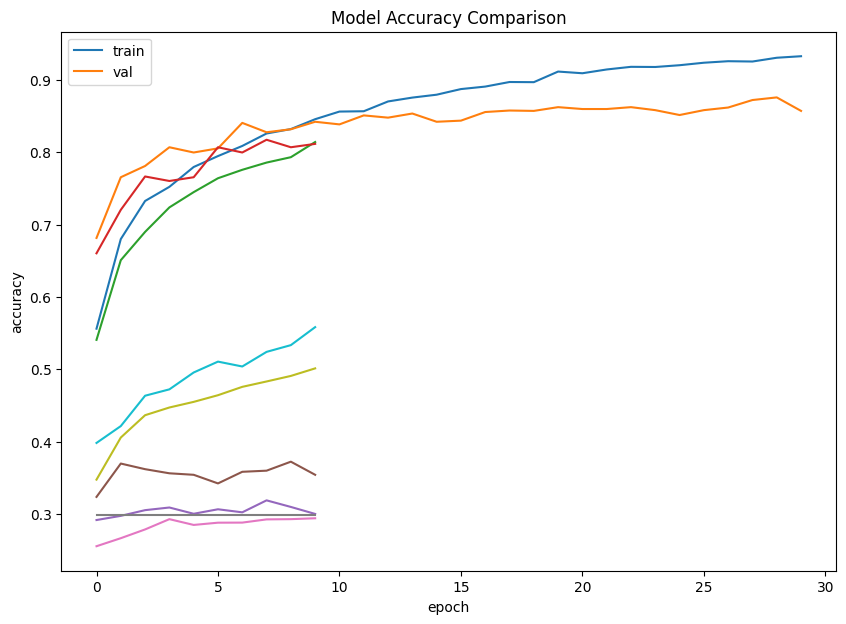

In [25]:
def plot_histories(histories, title):
    plt.figure(figsize=(10, 7))
    for history in histories:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_histories([vgg16_history, vgg19_history, resnet_history, efficientnet_history, cnn_history], 'Model Accuracy Comparison')